<a href="https://colab.research.google.com/github/BaronSnipes/Portfolio/blob/main/Predicting_the_NBA_MVP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
robertsunderhaft_nba_player_season_statistics_with_mvp_win_share_path = kagglehub.dataset_download('robertsunderhaft/nba-player-season-statistics-with-mvp-win-share')

print('Data source import complete.')



# NBA MVP Predictor

As a big fan of the NBA and sports statistics, I thought it would be a great project to try to predict the NBA MVP using Machine Learning.

So where do we begin. Well the most important part to any ML project is to obtain data to train and test our model on.

# Importing Data
For collecting data I web scraped the website [basketball-reference.com](https://www.basketball-reference.com). I scraped four types of stats: the regular season stats, the advanced season stats, the team's stats, and the MVP voting stats. I joined and cleaned this data on a seperate python script. The code for the web scrapers will be posted on github.

The data set I am using is also posted on Kaggle for anyone to use! I plan on keeping it current aswell.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('../input/nba-player-season-statistics-with-mvp-win-share/NBA_Dataset.csv')
df = df.fillna(0)

Now that we have our data we need to figure out how we are going to tackle this project.

What we want to predict is the MVP of the NBA, and the MVP is decided by a borda voting system. A borda voting system is where votes for first place are weighted heavier than votes for second or third place. In the case of the NBA, first place is worth 10 points, second is worth 7 points, third is 5 points, fourth is 3 points, and fifth is 1 point. Thus the player with the most points after the voting is concluded will be crowned the MVP.

Therefore to predict the MVP we want to predict how much of the total points a player obtained, which is called the award share. From this perspective, it sounds like we are going to use a supervised regression model for our predictions.

Now that we have some direction, let's start looking at the data.

# Feature Engineering and Data Preprocessing

After data cleaning, it is crucial to start doing Feature Engineering. In this process we manipulate the data so it is the most informative and useful for our model to train on.

The first feature that I added to the data was a boolean value denoting which player won the MVP award that year. It is true for the player that won and false for the players that didn't win. This will allow us to easily check if our predictions were accurate will testing.

In [ ]:
# This adds a column telling us who the MVP was with a boolean value
mvps = df.groupby(by = "season").max('award_share')
mvps["was_mvp"] = True
df = df.merge(mvps[["award_share", "was_mvp"]], on = ["season", "award_share"], how = "left")
df["was_mvp"] = df["was_mvp"].fillna(value = False)

In feature engineering we don't just add new features, we also remove features that are repetitive or add no value. If we do a simple EDA, we can see that several of the statistics within the data set can be derived from combinations of multiple stats. For example, we can derive fg_per_g by multiplying fga_per_g with fg_pct. Thus we can remove the variable fg_per_g from our data set. As one can see from the graph below, the derived stat and fg_per_g have a perfect correlation of 1. Thus we can remove fg_per_g. The same can be said for fg3_per_g, fg2_per_g, ft_per_g, and trb_per_g.

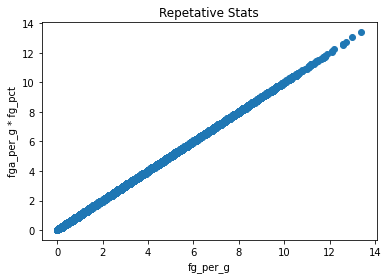

array([[1.        , 0.99990689],
       [0.99990689, 1.        ]])

In [ ]:
plt.scatter(df["fg_per_g"], df["fga_per_g"]*df["fg_pct"])
plt.xlabel("fg_per_g")
plt.ylabel("fga_per_g * fg_pct")
plt.title("Repetative Stats")
plt.show()
np.corrcoef(df["fg_per_g"], df["fga_per_g"]*df["fg_pct"])

In [ ]:
df = df.drop(columns = ["fg_per_g", "fg3_per_g", "fg2_per_g", "ft_per_g", "trb_per_g"], axis = 1)

# Representation Bias

A key problem in machine learning today is biased datasets. One type of bias is representation bias. This occurs when the data we train our model on is not a good representation of the real population data. This is a very simple definition of a very nuanced topic and I encourage you to read more about it in this
[great medium article written by Mary Reagan](https://towardsdatascience.com/understanding-bias-and-fairness-in-ai-systems-6f7fbfe267f3)


So what does this mean for our data? Well, we stated in the paper that the modern-day MVP voting didn't start until the 1980-81 season. Thus we should cut out all the data that was collected before that time since it wouldn't make sense to train our model with data from a different MVP voting system. Not only that but most common stats of today were not even recorded until the 1981 season.



In [ ]:
df = df[df["season"] > 1981]
len(df)

17697

Now that we have done some basic EDA to our model it is important we set aside a test set so we can see if our models truly have predictive power when it encounters brand new data

In [ ]:
dfTestSet = df[df["season"] == 2022]
df =  df[df["season"] < 2022]

## Imbalanced data

Great, we did some simple data cleaning but there is still one crucial factor that we must consider in preparing our data for modeling: imbalanced data.

Having imbalanced data means that our target class has an uneven distribution of observations with one subset of observations greatly outnumbering another subset of observations. The larger subset is called the majority class while the smaller subset is called the minority class. In our case, the number of players receiving MVP votes is much smaller than the number of players who didn't receive MVP votes.

The main problem of having an imbalanced data set is how to accurately predict the minority and majority classes. For example, if we were tasked with predicting credit card fraud where only 5% of the data is fraudulent, we could create a model that is 95% accurate by guessing that every transaction was not fraudulent. Though 95% accuracy seems fantastic from an outside perspective, it is not accomplishing the problem we want to solve at all.

Similarly, our MVP model could learn to always predict zero percent for the proportion of votes an NBA player received. Though the model would be accurate most of the time this does absolutely nothing in helping predict the next MVP. Thus it is better to balance the data to allow our model to truly learn the relationship a player's stats has with obtaining MVP votes.

There are many ways to balance an imbalanced dataset, but one of the best ways is to undersample the majority class first and then use SMOTE to synthetically generate new samples in the minority class.

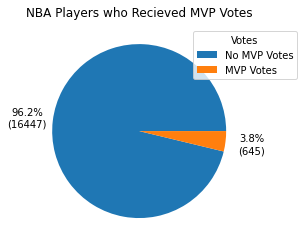

In [ ]:
from collections import Counter

classes = df["award_share"] > 0
infoDf = df[["player", "pos", "team_id"]]
dataDf = df.drop(["player", "pos", "team_id"], axis = 1)

def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n({:d})".format(pct, absolute)

fig, ax = plt.subplots()

wedges, texts, autotexts = ax.pie(classes.value_counts(),
       autopct = lambda pct: func(pct, classes.value_counts()),
       pctdistance = 1.3)

ax.set_title("NBA Players who Recieved MVP Votes")
ax.legend(["No MVP Votes", "MVP Votes"],
          title="Votes",
          loc = 'center right',
           bbox_to_anchor=(1.25, 0.85))

plt.show()

One of the most common methods for undersampling is called random undersampling. This is where we randomly remove a subset of the data from the majority class. Though this process can be effective, its major drawback is it can remove players whose stats might be meaningful to the model while keeping other players that have redundant statistics with no information.

Thus a better way for us to undersample the majority class is by removing players that have an extremely low chance of receiving votes. For example, we could remove players who score very few points, players who start very few games, and players that play very few minutes.

One can infer that a player must start a good number of games during the season to be considered MVP. The fewest amount of games started for a player to get an MVP award was 49 by Karl Malone in the 1998-1999 season, which also was one of the most controversial MVP races in NBA history. After looking at the distribution of games started by players who received MVP votes versus those who didn't, it would be a safe assumption that to be competitive in the MVP voting you must start at least 20 games.



In [ ]:
mvpShares = df[df["award_share"] > 0]
nonMvpShares = df[df["award_share"] == 0]

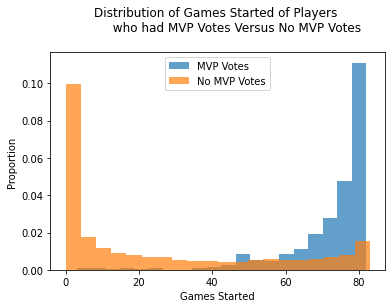

In [ ]:
plt.hist(mvpShares["gs"], bins = 20, alpha = 0.7, density=True, label = "MVP Votes")
plt.hist(nonMvpShares["gs"], bins = 20, alpha = 0.7, density=True, label = "No MVP Votes")
plt.ylabel("Proportion")
plt.xlabel("Games Started")
plt.title("""Distribution of Games Started of Players
          who had MVP Votes Versus No MVP Votes
          """)
plt.legend()
plt.show()

 But before I subset this data you might be wondering who were the players that started less than 20 games and still received NBA votes. When I took a deeper look I found some interesting votes.

The first 6 players seemed like normal outliers where they got one or two fourth or fifth place votes but then there was Derrick Rose in the 2020-2021 season and Michael Jordan in the 1994-1995 season.
In the 2020-2021 season, Derrick Rose played 50 games in total for the Detroit Pistons and the New York Knicks. He was a good role player at best and only start three games, but Derrick Rose scored a first-place MVP vote. Yes, someone thought Derrick rose was the best player in the NBA and he **ONLY STARTED 3 GAMES**!

The other notable outlier is of course the legend Michael Jordan in the 1994-1995 season. The 1994-1995 season was an interesting year because it was the one in which Jordan returned to basketball. MJ returned late just before the playoffs and only was able to get in 17 games. MJ played good basketball, but not to the standard the world was used to seeing him play at. With so few games played though he wouldn't have a chance of bringing home the MVP, but he was able to grab some votes.

After looking at these outliers it becomes obvious that the MVP is often subjective and doesn't always rely on the statistics themselves, but with many voters, it becomes possible to identify trends in the data that we can predict.

In [ ]:
mvpShares[mvpShares["gs"] < 20][["season", "player", "g", "gs", "pts_per_g", 'award_share']].reset_index(drop = True)

,season,player,g,gs,pts_per_g,award_share
0,1982,Michael Cooper,76,14,11.9,0.004
1,1991,Kevin McHale,68,10,18.4,0.001
2,1992,Detlef Schrempf,80,4,17.3,0.001
3,1995,Michael Jordan,17,17,26.9,0.011
4,1996,Magic Johnson,32,9,14.6,0.007
5,1999,Darrell Armstrong,50,15,13.8,0.002
6,1999,Rasheed Wallace,49,18,12.8,0.001
7,2021,Derrick Rose,50,3,14.7,0.010


When we take out the players who played less than 20 games we then reduce the data size to 7,132, which is roughly 2/5 of our original data set. Since we only took out 8 players who received MVP votes, we then removed 9,952 players that didn't start enough games to be considered MVP. This is great but our data set is still very imbalanced.

In [ ]:
df = df[df["gs"] > 20]
df = df.reset_index(drop = True)
len(df)

7132

To be an MVP, it seems logical that you get significant playing time on the court. Using this ideology, we can remove players from the dataset that have little playing time. By doing this we hope to undersample the majority class and reduce the amount of unnecessary data.

To identify a cutoff, I will use the third standard deviation from the mean minutes played per game by players who received MVP votes. This ended up being 27.890 points.

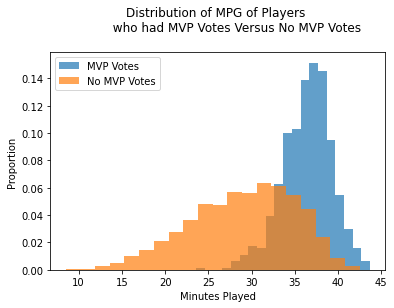

The cutoff is 27.890 minutes per game


In [ ]:
mvpShares = df[df["award_share"] > 0]
nonMvpShares = df[df["award_share"] == 0]

plt.hist(mvpShares["mp_per_g"], bins = 20, alpha = 0.7, density=True, label = "MVP Votes")
plt.hist(nonMvpShares["mp_per_g"], bins = 20, alpha = 0.7, density=True, label = "No MVP Votes")
plt.ylabel("Proportion")
plt.xlabel("Minutes Played")
plt.title("""Distribution of MPG of Players
          who had MVP Votes Versus No MVP Votes
          """)
plt.legend()
plt.show()

mp_cutoff = mvpShares["mp_per_g"].mean() - 3*mvpShares["mp_per_g"].std()
print(f"The cutoff is {mp_cutoff:.3f} minutes per game")


The two players who received MVP votes that got removed were Alton Lister and Arvydas Sabonis, who is the father of NBA Power Forward Domantas Sabonis. Again, it seems that both of these players are outliers who received minor votes.

In [ ]:
mvpShares[mvpShares["mp_per_g"] < mp_cutoff][["season", "player", "mp_per_g", "pts_per_g", 'award_share']].reset_index(drop = True)

,season,player,mp_per_g,pts_per_g,award_share
0,1983,Alton Lister,23.6,8.4,0.007
1,1999,Arvydas Sabonis,27.0,12.1,0.003


We can likewise do this with points scored in a game as it intuitively seems that the best player in the league should score a respectable amount of points to win MVP. The cutoff here was 7.092 points.


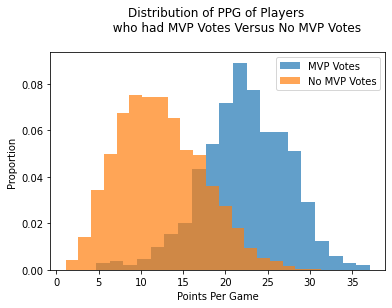

The cutoff is 7.092 points in a game


In [ ]:
plt.hist(mvpShares["pts_per_g"], bins = 20, alpha = 0.7, density=True, label = "MVP Votes")
plt.hist(nonMvpShares["pts_per_g"], bins = 20, alpha = 0.7, density=True, label = "No MVP Votes")
plt.xlabel("Points Per Game")
plt.ylabel("Proportion")
plt.title("""Distribution of PPG of Players
          who had MVP Votes Versus No MVP Votes
          """)
plt.legend()
plt.show()

pts_cutoff = mvpShares["pts_per_g"].mean() - 3 * mvpShares["pts_per_g"].std()
print(f"The cutoff is {pts_cutoff:.3f} points in a game")

With this subset, we are taking out four more players that received NBA MVP votes. Since this was a cutoff on points, it is natural to see big men that thrived on defensive and rebounding. These players were more valuable overall than in just their ability to score. Between the three of these players, they have 8 Defensive Player of the Year trophies, which is amazing.

Though Mark Eaton and Rodman didn't receive many votes, Ben Wallace did have a decent win share. This can be attributed to his amazing defense, as he won the defensive player of the year that season, and his rebounding ability, as he lead the league in rebounding. Though he had a great season, only scoring 6.9 points is likely not sufficient enough to gain a lot of MVP votes, especially in today's NBA.

In [ ]:
mvpShares[mvpShares["pts_per_g"] < pts_cutoff][["season", "player", "pts_per_g", 'blk_per_g', 'orb_per_g', 'drb_per_g', 'award_share']].reset_index(drop = True)

,season,player,pts_per_g,blk_per_g,orb_per_g,drb_per_g,award_share
0,1989,Mark Eaton,6.2,3.8,2.8,7.5,0.004
1,1994,Dennis Rodman,4.7,0.4,5.7,11.6,0.001
2,1996,Dennis Rodman,5.5,0.4,5.6,9.3,0.004
3,2003,Ben Wallace,6.9,3.2,4.0,11.4,0.028


After making these subsets we are able to reduce the size of our dataset by around 1,000 values.

In [ ]:
df = df[(df["pts_per_g"] > pts_cutoff) & (df["mp_per_g"] > mp_cutoff)].reset_index(drop = True)
df

,season,player,pos,age,team_id,g,gs,mp_per_g,fga_per_g,fg_pct,...,ws_per_48,obpm,dbpm,bpm,vorp,award_share,mov,mov_adj,win_loss_pct,was_mvp
0,1982,Kareem Abdul-Jabbar,C,34,LAL,76,76,35.2,17.1,0.579,...,0.192,3.8,1.2,5.0,4.7,0.045,4.87,4.37,0.695,False
1,1982,Alvan Adams,C,27,PHO,79,75,30.3,13.0,0.494,...,0.144,1.4,2.2,3.6,3.4,0.000,3.45,3.05,0.561,False
2,1982,Tiny Archibald,PG,33,BOS,68,51,31.9,9.6,0.472,...,0.115,1.4,-1.3,0.1,1.1,0.000,6.38,6.35,0.768,False
3,1982,Greg Ballard,SF,27,WSB,79,79,37.3,16.5,0.475,...,0.154,1.5,1.7,3.2,3.9,0.000,0.88,1.06,0.524,False
4,1982,Kent Benson,C,27,DET,75,72,32.9,10.7,0.505,...,0.101,0.0,0.4,0.4,1.5,0.000,-0.91,-0.63,0.476,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4468,2021,Andrew Wiggins,PF,25,GSW,71,71,33.3,14.9,0.477,...,0.080,0.0,-0.4,-0.4,1.0,0.000,1.06,1.10,0.542,False
4469,2021,Patrick Williams,PF,19,CHI,71,71,27.9,7.4,0.483,...,0.060,-2.8,0.4,-2.4,-0.2,0.000,-0.89,-0.94,0.431,False
4470,2021,Zion Williamson,PF,20,NOP,61,61,33.2,17.0,0.611,...,0.205,6.1,-0.3,5.8,4.0,0.000,-0.29,-0.20,0.431,False
4471,2021,Christian Wood,C,25,HOU,41,41,32.3,15.6,0.514,...,0.100,1.7,-0.3,1.4,1.1,0.000,-7.90,-7.50,0.236,False


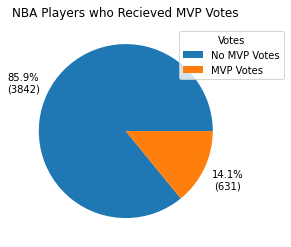

In [ ]:
from collections import Counter
from imblearn.over_sampling import SMOTE

classes = df["award_share"] > 0

dataDf = df.drop(["player", "pos", "team_id", "was_mvp"], axis = 1)
unSmoteLen = len(dataDf)

def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n({:d})".format(pct, absolute)

fig, ax = plt.subplots()

wedges, texts, autotexts = ax.pie(classes.value_counts(),
       autopct = lambda pct: func(pct, classes.value_counts()),
       pctdistance = 1.3)

ax.set_title("NBA Players who Recieved MVP Votes")

ax.legend(["No MVP Votes", "MVP Votes"],
          title="Votes",
          loc = 'center right',
           bbox_to_anchor=(1.25, 0.85))

plt.show()





Our dataset is looking much better, but it is still pretty imbalanced as only 14.1% of the players in our dataset have received MVP votes. To fix this problem we can use SMOTE to oversample over minority class.

SMOTE stands for Synthetic Minority Oversampling TEchnique and it does exactly what the name implies, it creates synthetic samples of the minority class. If you want to learn more about SMOTE I would recommend going to this article by [Jason Brownlee from his website Machine Learning Mastery](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/). Machine Learning Mastery mastery is also one of my favorite websites for learning new things about Machine Learning and helping me fix problems I am having while building a model.

After we apply SMOTE in the code below we can clearly see that our minority class has greatly increased in size and is now perfectly balanced!

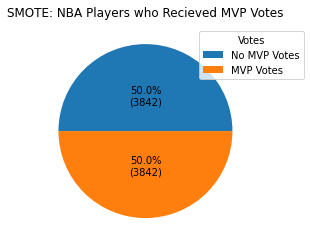

In [ ]:
smote = SMOTE(sampling_strategy = 1)
dataDf, classes = smote.fit_resample(dataDf, classes)

fig, ax = plt.subplots()

wedges, texts, autotexts = ax.pie(classes.value_counts(),
       autopct = lambda pct: func(pct, classes.value_counts()),
       pctdistance = 0.4)

ax.set_title("SMOTE: NBA Players who Recieved MVP Votes")

ax.legend(["No MVP Votes", "MVP Votes"],
          title="Votes",
          loc = 'center right',
           bbox_to_anchor=(1.25, 0.85))

plt.show()



Great, we oversampled our minority sample, but there is one issue with this data that we need to resolve. Since we created synthetic data, they don't belong to a real player or season. This will make it difficult to test who our MVP is since our synthetic data might be better than the true MVP of that year. Thus I must add labels to the data denoting which data is synthetic and which is not.

Since the SMOTE function adds the synthetic data to the end of the data set we can easily tell what our new data points are.

In [ ]:
dataDf["is_smote"] = dataDf.index >= unSmoteLen

In [ ]:
labeledDataDf = dataDf.merge(df, how = "left")

# The Boruta Method

We finally have a balanced dataset, but this is only half the battle. It is important to have a balanced dataset but we also need to make sure that the data we are putting in is not just noise.

Not all stats in the NBA are created equal. For example, assists per game is way less valuable than points per game for predicting the MVP. Many people think more data is better, but this is only true when the data we are adding is useful. If we start adding data that means nothing, like the number of gaterades consumed per game, it won't help our model. Thus we need to "select" the statistics that are most important to our model. This is called feature selection.

There are many ways of accomplishing this task but for this project I am using the Boruta method. The Boruta method is a statistical way of finding significant attributes for feature selection. To learn more about the Boruta method I would recommend this article, **which is unfortunately behind a paywall**, by [Samuele Mazzanti from Towards Data Science.](https://towardsdatascience.com/boruta-explained-the-way-i-wish-someone-explained-it-to-me-4489d70e154a)

In [ ]:
!pip install Boruta

^C
ERROR: Operation cancelled by user


***Note: If you are running this notebook the boruta algorithm will likely take a long time since it trains many random forests on the data***

***If you don't want to run the boruta algorithm I hard coded some columns that will allow the rest of the notebook to run***



In [ ]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
import numpy as np

rf = RandomForestRegressor(max_depth = 5, n_jobs=-1, n_estimators=500, oob_score=True)
trans = BorutaPy(rf, n_estimators = "auto", random_state=42, verbose=2)
selector = trans.fit(dataDf.drop(["award_share", "season", "is_smote"],axis= 1).to_numpy(),
                     dataDf["award_share"].to_numpy())


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	45
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	45
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	45
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	45
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	45
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	45
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	45
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	20
Tentative: 	18
Rejected: 	7
Iteration: 	9 / 100
Confirmed: 	20
Tentative: 	18
Rejected: 	7
Iteration: 	10 / 100
Confirmed: 	20
Tentative: 	18
Rejected: 	7
Iteration: 	11 / 100
Confirmed: 	20
Tentative: 	18
Rejected: 	7
Iteration: 	12 / 100
Confirmed: 	23
Tentative: 	11
Rejected: 	11
Iteration: 	13 / 100
Confirmed: 	23
Tentative: 	11
Rejected: 	11
Iteration: 	14 / 100
Confirmed: 	23
Tentative: 	11
Rejected: 	11
Iteration: 	15 / 100
Confirmed: 	23
Tentative: 	11
Rejected: 	11
Iteration: 	16 / 100
Confirmed: 	26
Tentative: 	8
Re

In [ ]:

columns = dataDf.drop(["award_share", "season", "is_smote"],axis= 1).columns[selector.ranking_ <= 2]

# If you don't want to run the Boruta method just this
# columns = ['age', 'g', 'gs', 'mp_per_g', 'fga_per_g', 'fg_pct',
#        'fg2a_per_g', 'fg2_pct', 'efg_pct', 'fta_per_g', 'ft_pct', 'drb_per_g',
#        'ast_per_g', 'stl_per_g', 'tov_per_g', 'pf_per_g', 'pts_per_g', 'mp',
#        'per', 'ts_pct', 'fta_per_fga_pct', 'drb_pct', 'trb_pct', 'ast_pct',
#        'stl_pct', 'tov_pct', 'usg_pct', 'ows', 'dws', 'ws', 'ws_per_48',
#        'obpm', 'dbpm', 'bpm', 'vorp', 'mov', 'win_loss_pct']


# Data Preprocessing
Great, we did most of the dirty work with the data but before we can train our model we need to split it into training set and testing sets.

One thing you might notice in the code below is that I don't standardize the data. When you are using tree based models you don't have to standardize data.

In [ ]:
dfTestSet = dfTestSet[(dfTestSet["gs"] > 20) & (dfTestSet["pts_per_g"] > pts_cutoff) & (dfTestSet["mp_per_g"] > mp_cutoff)].reset_index(drop = True)


In [ ]:
from pandas.core.dtypes.common import validate_all_hashable

# Shuffling the data
modelDf = labeledDataDf.sample(frac=1).reset_index(drop = True)

# Train Data
trainInfo = modelDf[["season", "player", "pos", "team_id","award_share",  "was_mvp", "is_smote"]]
trainData = modelDf[columns]
trainTargets = modelDf[["award_share"]]

# Test Data
testInfo = dfTestSet[["season", "player", "pos", "team_id", "award_share", "was_mvp"]]
testData = dfTestSet[columns]
testTargets = dfTestSet[["award_share"]]


# Random Forest Model

A popular method for creating good regression models is by using Random Forest Models.

Random Forest Models are a type of decision tree and decision trees can become very biased with unbalanced data. Thus we must balance the data before we run our model. In this instance, I am going to oversample the MVP players that received MVP votes.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

validation_scores = {"season" : [], "mae" : [], "was_mvp" : [], "was_top_two" : [], "was_top_three":[], "info" : []}
seasons = trainInfo.season.unique()
for season in seasons:
  print("\n")
  print(f"Season: {season}")

  trainFold = trainData[trainInfo["season"] != season]
  trainTarFold = trainTargets[trainInfo["season"] != season]
  valFold = trainData[(trainInfo["season"] == season) & (~trainInfo["is_smote"])]
  valTarFold = trainTargets[(trainInfo["season"] == season) & (~trainInfo["is_smote"])]
  valInfo = trainInfo[(trainInfo["season"] == season) & (~trainInfo["is_smote"])]

  regr = RandomForestRegressor(max_depth = 7, random_state=0)
  regr.fit(trainFold.to_numpy(), trainTarFold.to_numpy()[:,0])

  valPred = regr.predict(valFold)
  mae = np.mean(np.absolute(valPred - valTarFold.to_numpy()[:,0]))

  print(f"MAE: {mae}")

  topTwo = valInfo.iloc[np.argsort(valPred)[-2:]]
  was_top_two = sum(topTwo["was_mvp"]) > 0
  topThree = valInfo.iloc[np.argsort(valPred)[-3:]]
  was_top_three = sum(topThree["was_mvp"]) > 0
  print("Predicted top three players in MVP voting with their actual award_share:")
  print(topThree.iloc[::-1])


  mostVotes = np.argmax(valPred)
  score = np.amax(valPred)
  was_mvp = valInfo.iloc[[mostVotes]]["was_mvp"].values[0]
  player = valInfo.iloc[[mostVotes]]["player"].values[0]
  print(f"Predicted MVP: {player}")
  print(f"Predicted Win Share: {score}")
  print(f"Was MVP correct: {was_mvp}")

  validation_scores["season"].append(season)
  validation_scores["mae"].append(mae)
  validation_scores["was_mvp"].append(was_mvp)
  validation_scores["was_top_two"].append(was_top_three)
  validation_scores["was_top_three"].append(was_top_three)
  validation_scores["info"].append(valInfo.iloc[[mostVotes]])



Season: 1986


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


MAE: 0.015429146688119667
Predicted top three players in MVP voting with their actual award_share:
      season           player pos team_id  award_share was_mvp  is_smote
2288    1986       Larry Bird  SF     BOS        0.981    True     False
6103    1986    Magic Johnson  PG     LAL        0.263   False     False
2811    1986  Charles Barkley  PF     PHI        0.171   False     False
Predicted MVP: Larry Bird
Predicted Win Share: 0.7122223577196859
Was MVP correct: True


Season: 1985


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


MAE: 0.011819379619646481
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
3074    1985      Larry Bird  SF     BOS        0.978    True     False
7663    1985   Magic Johnson  PG     LAL        0.338   False     False
5586    1985  Michael Jordan  SG     CHI        0.172   False     False
Predicted MVP: Larry Bird
Predicted Win Share: 0.7723476539149998
Was MVP correct: True


Season: 1995


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


MAE: 0.009846525357352991
Predicted top three players in MVP voting with their actual award_share:
      season            player pos team_id  award_share was_mvp  is_smote
393     1995    David Robinson   C     SAS        0.858    True     False
5230    1995       Karl Malone  PF     UTA        0.507   False     False
3175    1995  Shaquille O'Neal   C     ORL        0.576   False     False
Predicted MVP: David Robinson
Predicted Win Share: 0.7746553194148734
Was MVP correct: True


Season: 2002


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


MAE: 0.0182295682835306
Predicted top three players in MVP voting with their actual award_share:
      season            player pos team_id  award_share was_mvp  is_smote
3698    2002        Tim Duncan  PF     SAS        0.757    True     False
5378    2002  Shaquille O'Neal   C     LAL        0.552   False     False
1072    2002        Jason Kidd  PG     NJN        0.712   False     False
Predicted MVP: Tim Duncan
Predicted Win Share: 0.6322585997291936
Was MVP correct: True


Season: 2014


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


MAE: 0.01668108676313508
Predicted top three players in MVP voting with their actual award_share:
      season        player pos team_id  award_share was_mvp  is_smote
7554    2014  Kevin Durant  SF     OKC        0.986    True     False
502     2014  LeBron James  PF     MIA        0.713   False     False
3507    2014    Kevin Love  PF     MIN        0.020   False     False
Predicted MVP: Kevin Durant
Predicted Win Share: 0.774931702355442
Was MVP correct: True


Season: 1996


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


MAE: 0.013097505236056644
Predicted top three players in MVP voting with their actual award_share:
      season             player pos team_id  award_share was_mvp  is_smote
3295    1996     Michael Jordan  SG     CHI        0.986    True     False
6030    1996     David Robinson   C     SAS        0.508   False     False
787     1996  Anfernee Hardaway  PG     ORL        0.319   False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.944885442279107
Was MVP correct: True


Season: 2007


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


MAE: 0.019043362225107146
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
4363    2007  Dirk Nowitzki  PF     DAL        0.882    True     False
2385    2007     Steve Nash  PG     PHO        0.785   False     False
1936    2007     Tim Duncan   C     SAS        0.222   False     False
Predicted MVP: Dirk Nowitzki
Predicted Win Share: 0.543962149537955
Was MVP correct: True


Season: 2001


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


MAE: 0.024170544234153744
Predicted top three players in MVP voting with their actual award_share:
      season            player pos team_id  award_share was_mvp  is_smote
377     2001        Tim Duncan  PF     SAS        0.569   False     False
7472    2001  Shaquille O'Neal   C     LAL        0.466   False     False
3984    2001     Allen Iverson  SG     PHI        0.904    True     False
Predicted MVP: Tim Duncan
Predicted Win Share: 0.39662193930782996
Was MVP correct: False


Season: 1990


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


MAE: 0.01597716476247597
Predicted top three players in MVP voting with their actual award_share:
      season           player pos team_id  award_share was_mvp  is_smote
7141    1990    Magic Johnson  PG     LAL        0.691    True     False
4223    1990   Michael Jordan  SG     CHI        0.613   False     False
5724    1990  Charles Barkley  SF     PHI        0.667   False     False
Predicted MVP: Magic Johnson
Predicted Win Share: 0.7164824056321839
Was MVP correct: True


Season: 2009


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


MAE: 0.014310397659680205
Predicted top three players in MVP voting with their actual award_share:
      season        player pos team_id  award_share was_mvp  is_smote
2443    2009  LeBron James  SF     CLE        0.969    True     False
5866    2009   Dwyane Wade  SG     MIA        0.562   False     False
2754    2009    Chris Paul  PG     NOH        0.159   False     False
Predicted MVP: LeBron James
Predicted Win Share: 0.9458221632173648
Was MVP correct: True


Season: 2008


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


MAE: 0.021909202295597473
Predicted top three players in MVP voting with their actual award_share:
      season        player pos team_id  award_share was_mvp  is_smote
2523    2008   Kobe Bryant  SG     LAL        0.873    True     False
5771    2008    Chris Paul  PG     NOH        0.710   False     False
4455    2008  LeBron James  SF     CLE        0.348   False     False
Predicted MVP: Kobe Bryant
Predicted Win Share: 0.692297239800887
Was MVP correct: True


Season: 2006


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


MAE: 0.024907545026511508
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
3973    2006  Dirk Nowitzki  PF     DAL        0.435   False     False
7016    2006   LeBron James  SF     CLE        0.550   False     False
5532    2006    Kobe Bryant  SG     LAL        0.386   False     False
Predicted MVP: Dirk Nowitzki
Predicted Win Share: 0.4915297009481808
Was MVP correct: False


Season: 2012


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


MAE: 0.02080467518604105
Predicted top three players in MVP voting with their actual award_share:
      season        player pos team_id  award_share was_mvp  is_smote
2867    2012  LeBron James  SF     MIA        0.888    True     False
452     2012  Kevin Durant  SF     OKC        0.735   False     False
6566    2012  Derrick Rose  PG     CHI        0.004   False     False
Predicted MVP: LeBron James
Predicted Win Share: 0.5892778803483604
Was MVP correct: True


Season: 2003


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


MAE: 0.013506861743666507
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
3788    2003     Tim Duncan  PF     SAS        0.808    True     False
5570    2003  Kevin Garnett  PF     MIN        0.732   False     False
1660    2003  Tracy McGrady  SG     ORL        0.359   False     False
Predicted MVP: Tim Duncan
Predicted Win Share: 0.6337929469311001
Was MVP correct: True


Season: 1991


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


MAE: 0.013209835536653064
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
1532    1991  Michael Jordan  SG     CHI        0.928    True     False
1404    1991  David Robinson   C     SAS        0.496   False     False
1760    1991   Magic Johnson  PG     LAL        0.518   False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.8847146089886668
Was MVP correct: True


Season: 2015


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


MAE: 0.016392503605712754
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
103     2015  Stephen Curry  PG     GSW        0.922    True     False
5658    2015   James Harden  SG     HOU        0.720   False     False
3402    2015   LeBron James  SF     CLE        0.425   False     False
Predicted MVP: Stephen Curry
Predicted Win Share: 0.6993200922140184
Was MVP correct: True


Season: 2016


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


MAE: 0.016136172238906614
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
6682    2016  Stephen Curry  PG     GSW        1.000    True     False
3605    2016   Kevin Durant  SF     OKC        0.112   False     False
1501    2016   LeBron James  SF     CLE        0.482   False     False
Predicted MVP: Stephen Curry
Predicted Win Share: 0.8985383694939402
Was MVP correct: True


Season: 1994


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


MAE: 0.01485890645745582
Predicted top three players in MVP voting with their actual award_share:
      season           player pos team_id  award_share was_mvp  is_smote
4002    1994   David Robinson   C     SAS        0.723   False     False
1773    1994  Hakeem Olajuwon   C     HOU        0.880    True     False
7404    1994    Patrick Ewing   C     NYK        0.252   False     False
Predicted MVP: David Robinson
Predicted Win Share: 0.749475017833623
Was MVP correct: False


Season: 1999


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


MAE: 0.022176271360871525
Predicted top three players in MVP voting with their actual award_share:
      season            player pos team_id  award_share was_mvp  is_smote
981     1999  Shaquille O'Neal   C     LAL        0.075   False     False
6180    1999       Karl Malone  PF     UTA        0.701    True     False
255     1999   Alonzo Mourning   C     MIA        0.655   False     False
Predicted MVP: Shaquille O'Neal
Predicted Win Share: 0.26091013649444234
Was MVP correct: False


Season: 1984


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


MAE: 0.017576457655941593
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
3655    1984      Larry Bird  PF     BOS        0.858    True     False
3233    1984   Magic Johnson  PG     LAL        0.401   False     False
4541    1984  Adrian Dantley  SF     UTA        0.116   False     False
Predicted MVP: Larry Bird
Predicted Win Share: 0.6312250865885385
Was MVP correct: True


Season: 1992


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


MAE: 0.012669189002443756
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
2146    1992  Michael Jordan  SG     CHI        0.938    True     False
6979    1992   Clyde Drexler  SG     POR        0.584   False     False
3928    1992     Karl Malone  PF     UTA        0.273   False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.9105079529802849
Was MVP correct: True


Season: 2011


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


MAE: 0.01465307238006697
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
2896    2011   Derrick Rose  PG     CHI        0.977    True     False
4905    2011   LeBron James  SF     MIA        0.431   False     False
7359    2011  Dwight Howard   C     ORL        0.531   False     False
Predicted MVP: Derrick Rose
Predicted Win Share: 0.7814067425894499
Was MVP correct: True


Season: 1993


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


MAE: 0.012224359732240451
Predicted top three players in MVP voting with their actual award_share:
      season           player pos team_id  award_share was_mvp  is_smote
3533    1993   Michael Jordan  SG     CHI        0.577   False     False
709     1993  Charles Barkley  PF     PHO        0.852    True     False
2336    1993  Hakeem Olajuwon   C     HOU        0.660   False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.663257373818072
Was MVP correct: False


Season: 2019


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


MAE: 0.017631113205701213
Predicted top three players in MVP voting with their actual award_share:
      season                 player pos team_id  award_share was_mvp  is_smote
2227    2019           James Harden  PG     HOU        0.768   False     False
5925    2019  Giannis Antetokounmpo  PF     MIL        0.932    True     False
4466    2019           Nikola Jokić   C     DEN        0.210   False     False
Predicted MVP: James Harden
Predicted Win Share: 0.6775784823916371
Was MVP correct: False


Season: 2020


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


MAE: 0.013495861121533595
Predicted top three players in MVP voting with their actual award_share:
      season                 player pos team_id  award_share was_mvp  is_smote
4014    2020  Giannis Antetokounmpo  PF     MIL        0.952    True     False
1708    2020           LeBron James  PG     LAL        0.746   False     False
2803    2020           James Harden  SG     HOU        0.363   False     False
Predicted MVP: Giannis Antetokounmpo
Predicted Win Share: 0.7494753539293447
Was MVP correct: True


Season: 2005


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


MAE: 0.023170610020118623
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
6521    2005     Steve Nash  PG     PHO        0.839    True     False
1357    2005  Kevin Garnett  PF     MIN        0.012   False     False
5323    2005  Dirk Nowitzki  PF     DAL        0.275   False     False
Predicted MVP: Steve Nash
Predicted Win Share: 0.5847692622253079
Was MVP correct: True


Season: 1989


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


MAE: 0.01446245002847165
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
279     1989  Michael Jordan  SG     CHI        0.704   False     False
4276    1989   Magic Johnson  PG     LAL        0.782    True     False
6117    1989     Karl Malone  PF     UTA        0.426   False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.6739098637358883
Was MVP correct: False


Season: 1997


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


MAE: 0.012122762039873397
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
5552    1997  Michael Jordan  SG     CHI        0.832   False     False
4972    1997     Karl Malone  PF     UTA        0.857    True     False
1974    1997      Grant Hill  SF     DET        0.327   False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.8524621970315536
Was MVP correct: False


Season: 1988


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


MAE: 0.01759809151167085
Predicted top three players in MVP voting with their actual award_share:
      season           player pos team_id  award_share was_mvp  is_smote
6352    1988   Michael Jordan  SG     CHI        0.831    True     False
4662    1988       Larry Bird  SF     BOS        0.659   False     False
7158    1988  Charles Barkley  PF     PHI        0.136   False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.6632429233135637
Was MVP correct: True


Season: 2010


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


MAE: 0.01653160277416953
Predicted top three players in MVP voting with their actual award_share:
      season        player pos team_id  award_share was_mvp  is_smote
4761    2010  LeBron James  SF     CLE        0.980    True     False
1550    2010  Kevin Durant  SF     OKC        0.495   False     False
5916    2010   Dwyane Wade  SG     MIA        0.097   False     False
Predicted MVP: LeBron James
Predicted Win Share: 0.9150422103883848
Was MVP correct: True


Season: 1982


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


MAE: 0.019405173195015273
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
4486    1982   Moses Malone   C     HOU        0.735    True     False
6998    1982  Julius Erving  SF     PHI        0.294   False     False
5421    1982     Larry Bird  PF     BOS        0.588   False     False
Predicted MVP: Moses Malone
Predicted Win Share: 0.4375005444883926
Was MVP correct: True


Season: 1983


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


MAE: 0.016597187080798513
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
2312    1983   Moses Malone   C     PHI        0.960    True     False
3096    1983     Larry Bird  PF     BOS        0.485   False     False
4250    1983  Magic Johnson  SG     LAL        0.406   False     False
Predicted MVP: Moses Malone
Predicted Win Share: 0.6426512144828869
Was MVP correct: True


Season: 2013


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


MAE: 0.012359965283512275
Predicted top three players in MVP voting with their actual award_share:
      season        player pos team_id  award_share was_mvp  is_smote
6334    2013  LeBron James  PF     MIA        0.998    True     False
1426    2013  Kevin Durant  SF     OKC        0.632   False     False
5470    2013    Chris Paul  PG     LAC        0.239   False     False
Predicted MVP: LeBron James
Predicted Win Share: 0.7965215224604976
Was MVP correct: True


Season: 2021


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


MAE: 0.01786002424712978
Predicted top three players in MVP voting with their actual award_share:
      season                 player pos team_id  award_share was_mvp  is_smote
1771    2021           Nikola Jokić   C     DEN        0.961    True     False
2035    2021            Joel Embiid   C     PHI        0.580   False     False
96      2021  Giannis Antetokounmpo  PF     MIL        0.345   False     False
Predicted MVP: Nikola Jokić
Predicted Win Share: 0.7360492107847719
Was MVP correct: True


Season: 2000


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


MAE: 0.010869099436733224
Predicted top three players in MVP voting with their actual award_share:
      season            player pos team_id  award_share was_mvp  is_smote
4561    2000  Shaquille O'Neal   C     LAL        0.998    True     False
7670    2000       Karl Malone  PF     UTA        0.258   False     False
1306    2000        Tim Duncan  PF     SAS        0.205   False     False
Predicted MVP: Shaquille O'Neal
Predicted Win Share: 0.9099898817576886
Was MVP correct: True


Season: 1998


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


MAE: 0.01317959710459804
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
854     1998     Karl Malone  PF     UTA        0.726   False     False
3988    1998  Michael Jordan  SG     CHI        0.934    True     False
4539    1998  David Robinson   C     SAS        0.031   False     False
Predicted MVP: Karl Malone
Predicted Win Share: 0.7098096954093868
Was MVP correct: False


Season: 2004


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


MAE: 0.018168837218021636
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
672     2004  Kevin Garnett  PF     MIN        0.991    True     False
6438    2004     Tim Duncan  PF     SAS        0.582   False     False
7353    2004     Jason Kidd  PG     NJN        0.014   False     False
Predicted MVP: Kevin Garnett
Predicted Win Share: 0.7998976074517175
Was MVP correct: True


Season: 2018


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


MAE: 0.017642243157238776
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
2418    2018   James Harden  SG     HOU        0.955    True     False
6215    2018   LeBron James  PF     CLE        0.731   False     False
2374    2018  Anthony Davis  PF     NOP        0.441   False     False
Predicted MVP: James Harden
Predicted Win Share: 0.8184775401207887
Was MVP correct: True


Season: 2017


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


MAE: 0.026295831956174083
Predicted top three players in MVP voting with their actual award_share:
      season             player pos team_id  award_share was_mvp  is_smote
684     2017  Russell Westbrook  PG     OKC        0.879    True     False
4695    2017      Kawhi Leonard  SF     SAS        0.495   False     False
3434    2017       James Harden  PG     HOU        0.746   False     False
Predicted MVP: Russell Westbrook
Predicted Win Share: 0.6125367388184185
Was MVP correct: True


Season: 1987
MAE: 0.015333193125633979
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
2120    1987   Magic Johnson  PG     LAL        0.940    True     False
875     1987      Larry Bird  SF     BOS        0.347   False     False
5324    1987  Michael Jordan  SG     CHI        0.576   False     False
Predicted MVP: Magic Johnson
Predicted Win Share: 0.6828122666682523
Was MVP correct: True


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [ ]:
print(f"The Random Forest Model predicted the NBA MVP correctly {sum(validation_scores['was_mvp'])/len(seasons)}% of the time")
print(f"The Random Forest Model predicted the NBA MVP correctly in the top two {sum(validation_scores['was_top_two'])/len(seasons)}% of the time")
print(f"The Random Forest Model predicted the NBA MVP correctly in the top three {sum(validation_scores['was_top_three'])/len(seasons)}% of the time")


The Random Forest Model predicted the NBA MVP correctly 0.775% of the time
The Random Forest Model predicted the NBA MVP correctly in the top two 0.975% of the time
The Random Forest Model predicted the NBA MVP correctly in the top three 0.975% of the time


# XGBoost Model

To get the best results, we must test multiple different models.

One of the most popular models for machine learning competition is the XGBoost Model. Like the random forest model it is an ensemble model composed of decision trees. If you want to learn more please check out the [xgboost documentation](https://xgboost.readthedocs.io/en/stable/tutorials/model.html).



In [ ]:
from xgboost import XGBRegressor

In [ ]:
validation_scores = {"season" : [], "mae" : [], "was_mvp" : [], "was_top_two" : [], "was_top_three":[], "info" : []}
seasons = trainInfo.season.unique()

for season in seasons:
  print("\n")
  print(f"Season: {season}")

  trainFold = trainData[trainInfo["season"] != season]
  trainTarFold = trainTargets[trainInfo["season"] != season]
  valFold = trainData[(trainInfo["season"] == season) & (~trainInfo["is_smote"])]
  valTarFold = trainTargets[(trainInfo["season"] == season) & (~trainInfo["is_smote"])]
  valInfo = trainInfo[(trainInfo["season"] == season) & (~trainInfo["is_smote"])]

  regr = XGBRegressor(objective='reg:squarederror', random_state=0, max_depth = 6)
  regr.fit(trainFold, trainTarFold)

  valPred = regr.predict(valFold)
  mae = np.mean(np.absolute(valPred - valTarFold.to_numpy()[:,0]))
  print(f"MAE: {mae}")

  topTwo = valInfo.iloc[np.argsort(valPred)[-2:]]
  was_top_two = sum(topTwo["was_mvp"]) > 0
  topThree = valInfo.iloc[np.argsort(valPred)[-3:]]
  was_top_three = sum(topThree["was_mvp"]) > 0
  print("Predicted top three players in MVP voting with their actual award_share:")
  print(topThree.iloc[::-1])

  mostVotes = np.argmax(valPred)
  score = np.amax(valPred)
  was_mvp = valInfo.iloc[[mostVotes]]["was_mvp"].values[0]
  print(f"Predicted MVP: {player}")
  print(f"Predicted Win Share: {score}")
  print(f"Was MVP correct: {was_mvp}")

  validation_scores["season"].append(season)
  validation_scores["mae"].append(mae)
  validation_scores["was_mvp"].append(was_mvp)
  validation_scores["info"].append(valInfo.iloc[[mostVotes]])
  validation_scores["was_top_two"].append(was_top_two)
  validation_scores["was_top_three"].append(was_top_three)




Season: 1986
MAE: 0.016234329487689925
Predicted top three players in MVP voting with their actual award_share:
      season           player pos team_id  award_share was_mvp  is_smote
2288    1986       Larry Bird  SF     BOS        0.981    True     False
6103    1986    Magic Johnson  PG     LAL        0.263   False     False
2811    1986  Charles Barkley  PF     PHI        0.171   False     False
Predicted MVP: Magic Johnson
Predicted Win Share: 0.8051255345344543
Was MVP correct: True


Season: 1985
MAE: 0.010350988229054583
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
3074    1985     Larry Bird  SF     BOS        0.978    True     False
7663    1985  Magic Johnson  PG     LAL        0.338   False     False
2294    1985   Moses Malone   C     PHI        0.279   False     False
Predicted MVP: Magic Johnson
Predicted Win Share: 0.8752307891845703
Was MVP correct: True


Season: 1995

In [ ]:
print(f"The XGBoost Model predicted the NBA MVP correctly {sum(validation_scores['was_mvp'])/len(seasons)}% of the time")
print(f"The XGBoost Model predicted the NBA MVP correctly in the top two {sum(validation_scores['was_top_two'])/len(seasons)}% of the time")
print(f"The XGBoost Model predicted the NBA MVP correctly in the top three {sum(validation_scores['was_top_three'])/len(seasons)}% of the time")


The XGBoost Model predicted the NBA MVP correctly 0.825% of the time
The XGBoost Model predicted the NBA MVP correctly in the top two 0.975% of the time
The XGBoost Model predicted the NBA MVP correctly in the top three 0.975% of the time


# Test Set
It seems that the XGBoost model performed the best out of any model. Finally we can run our model on our test set, which is the season of 2022. Our model will be trained on all the training data as well.

In [ ]:
regr = XGBRegressor(objective='reg:squarederror', max_depth=7)
regr.fit(trainData, trainTargets)

testPred = regr.predict(testData)
mae = np.mean(np.absolute(testPred - testTargets.to_numpy()[:,0]))
print(f"MAE: {mae}")
print(np.argsort(testPred)[-1:])

topTwo = testInfo.iloc[np.argsort(testPred)[-2:]]
was_top_two = sum(topTwo["was_mvp"]) > 0
topThree = testInfo.iloc[np.argsort(testPred)[-3:]]
was_top_three = sum(topThree["was_mvp"]) > 0

topTen = testInfo.iloc[np.argsort(testPred)[-10:]]
print("Predicted top three players in MVP voting with their actual award_share:")
print(topTen.iloc[::-1])

mostVotes = np.argmax(testPred)
score = np.amax(testPred)
was_mvp = testInfo.iloc[[mostVotes]]["was_mvp"].values[0]
print(f"Predicted MVP: {player}")
print(f"Predicted Win Share: {score}")
print(f"Was MVP correct: {was_mvp}")

MAE: 0.019126300298818816
[74]
Predicted top three players in MVP voting with their actual award_share:
    season                 player pos team_id  award_share  was_mvp
74    2022           Nikola Jokić   C     DEN        0.875     True
2     2022  Giannis Antetokounmpo  PF     MIL        0.595    False
97    2022             Chris Paul  PG     PHO        0.002    False
38    2022            Luka Dončić  PG     DAL        0.146    False
43    2022            Joel Embiid   C     PHI        0.706    False
41    2022           Kevin Durant  PF     BRK        0.001    False
72    2022           LeBron James  PF     LAL        0.001    False
90    2022              Ja Morant  PG     MEM        0.010    False
34    2022          Stephen Curry  PG     GSW        0.004    False
51    2022            Rudy Gobert   C     UTA        0.000    False
Predicted MVP: Magic Johnson
Predicted Win Share: 0.8085033297538757
Was MVP correct: True


Great! Our model was able to predict that the 2022 MVP was Nikola Jokić. Since our model was able to correctly predict our test set, we will be able to use this model on the 2023 model with confidence!

# Future Improvements

This was a good start to predicting the NBA MVP but it can be vastly improved. Currently, I am taking all the players in the NBA in a given season to train our model and predict who the MVP will be. As you have seen from the models above it works great in predicting who the top candidates for the MVP award will be but it lacks in accuracy when trying to predict the MVP itself, hovering around 80% accuracy.

To further improve this model we can do two things, create more models and spend more time doing feature engineering.

Since my model does a good job in predicting the top MVP candidates, I can use these results and feed them into another model that was solely trained on players who received MVP votes. This would narrow the scope of the model allowing for better predictions when it comes to predicting the win-share of MVP-caliber players.

Another aspect of this project I would like to explore is how different models for different eras of the NBA would perform. There are analytics showing that different seasons have different play styles and I wanted to test if these play styles have any impact on model predictions. Currently, the NBA is in an era where three-point shots are king. Does this mean three-point shots are more valuable in the MVP than in previous years? Probably, but it also raises the question of how the impact of other stats has changed over the years.

This was my first end-to-end machine learning project that I have put out into the world but I intend to keep on improving this model over the years. There are so many more avenues and ways to improve this model and it even has different applications other than just predicting the MVP. For example, a similar model could predict rookie of the year, defensive player of the year, etc.

Lastly, I wanted to give a big thanks to David Yoo. He is a data scientist that also tackled this project and has a [great medium article about it](https://medium.com/towards-data-science/predicting-the-next-nba-mvp-using-machine-learning-62615bfcff75). I reached out to David and he was able to give me some advice on the project that improved my results in the end. If you have the time definitely check out his approach!